In [10]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import tensorflow as tf
from scipy import signal
from math import ceil
import seaborn as sns
from scipy import stats

In [11]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

In [12]:
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Patient Real Heart Rate')
    plt.plot(predicted, color='blue',label='Patient Predicted Heart Rate')
    plt.title('Heart Rate Prediction')
    plt.xlabel('Time')
    plt.ylabel('mV')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    mae =mean_absolute_error(test, predicted)
    print(f"The mean absolute error is {mae}.")

In [13]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

In [14]:
def create_time_steps(length):
    return list(range(-length, 0))

In [15]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History',kind='line')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',label='True Future',kind='line')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro')
    plt.legend(loc='upper left')
    plt.show()

In [16]:
tf.random.set_seed(13)

In [18]:
df = pd.read_csv('../../data/raw/14046_2teste.csv', index_col='t')
df.head()

,mV
t,
0.000,0.16
0.008,0.18
0.016,0.17
0.023,0.18
0.031,0.18


In [19]:
int(df.shape[0] * 0.5)

9668

In [20]:
df.tail(5)

,mV
t,
150.961,0.05
150.969,0.05
150.977,0.08
150.984,0.09
150.992,0.09


## Training for 60% of the base

In [99]:
train = df.iloc[0:int(df.shape[0]*0.5)].values

In [100]:
test = df.iloc[int(df.shape[0]*0.5):].values

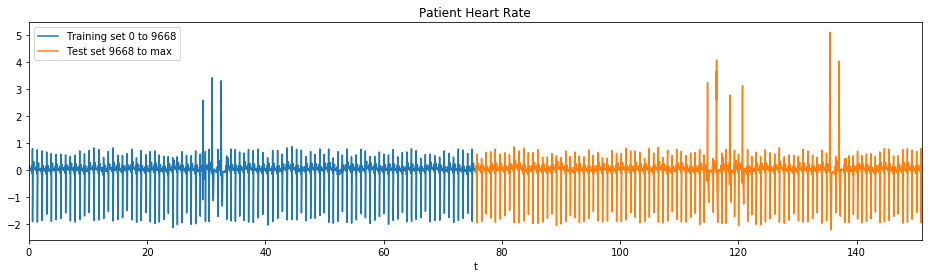

In [101]:
df["mV"].iloc[0:int(df.shape[0]*0.5)].plot(figsize=(16,4),legend=True)
df["mV"].iloc[int(df.shape[0]*0.5):].plot(figsize=(16,4),legend=True)
plt.legend([f'Training set 0 to {int(df.shape[0]/2)}',f'Test set {int(df.shape[0]/2)} to max'])
plt.title('Patient Heart Rate')
plt.show()

In [102]:
uni_data = df['mV']
uni_data.head()

t
0.000    0.16
0.008    0.18
0.016    0.17
0.023    0.18
0.031    0.18
Name: mV, dtype: float64

In [103]:
uni_data = uni_data.values

In [104]:
uni_train_mean = uni_data[:int(df.shape[0]*0.5)].mean()
uni_train_std = uni_data[:int(df.shape[0]*0.5)].std()

In [105]:
uni_train_mean

-0.01317335539925527

In [106]:
uni_train_std

0.33492606608181086

Let's standardize the data.

In [107]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

In [108]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, int(df.shape[0]*0.5),
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, int(df.shape[0]*0.5), None,
                                       univariate_past_history,
                                       univariate_future_target)

In [109]:
y_train_uni

array([ 0.03933213,  0.0990468 ,  0.12890414, ..., -0.13981188,
       -0.13981188, -0.10995455])

# Model testing

In [110]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_uni.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(1))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

In [111]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_data_multi = train_data_multi.cache().shuffle(1000).batch(500).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_data_multi = val_data_multi.batch(1000).repeat()

In [112]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=10,
                                          steps_per_epoch=100,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Train for 100 steps, validate for 50 steps
Epoch 1/10
100/100 [==============================] - 6s 57ms/step - loss: 0.3355 - val_loss: 0.3294
Epoch 2/10
100/100 [==============================] - 3s 35ms/step - loss: 0.2520 - val_loss: 0.2649
Epoch 3/10
100/100 [==============================] - 4s 36ms/step - loss: 0.2108 - val_loss: 0.2328
Epoch 4/10
100/100 [==============================] - 4s 35ms/step - loss: 0.1919 - val_loss: 0.2148
Epoch 5/10
100/100 [==============================] - 3s 34ms/step - loss: 0.1729 - val_loss: 0.1956
Epoch 6/10
100/100 [==============================] - 3s 34ms/step - loss: 0.1565 - val_loss: 0.1789
Epoch 7/10
100/100 [==============================] - 3s 33ms/step - loss: 0.1477 - val_loss: 0.1634
Epoch 8/10
100/100 [==============================] - 3s 33ms/step - loss: 0.1391 - val_loss: 0.1553
Epoch 9/10
100/100 [==============================] - 3s 33ms/step - loss: 0.1306 - val_loss: 0.1442
Epoch 10/10
100/100 [===========================

## Multi-Step Training

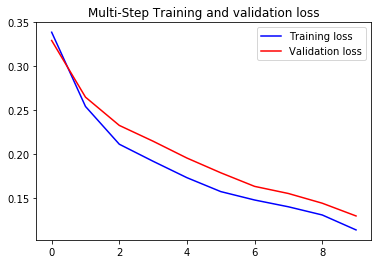

In [113]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

In [114]:
val_data_multi.take(30)

<TakeDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>

In [115]:
STEP = 1

In [116]:
x = val_data_multi.take(10)

result for ks on test is KstestResult(statistic=0.32292543599558676, pvalue=2.652455889146099e-93)
result for ks on prediction is KstestResult(statistic=0.9999999961099203, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.9422411045975089, pvalue=0.0)


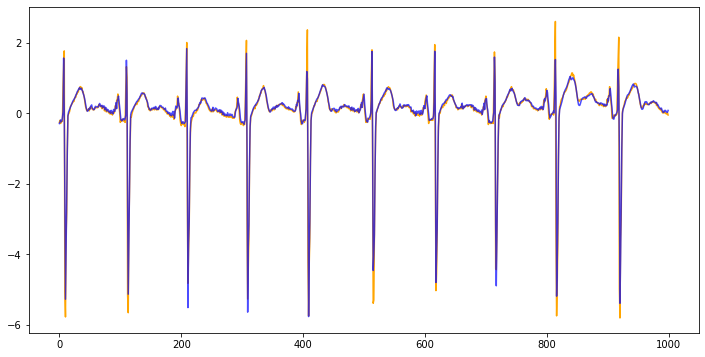

result for ks on test is KstestResult(statistic=0.30825297640366595, pvalue=7.208821286236311e-85)
result for ks on prediction is KstestResult(statistic=0.9999999966230706, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.9318063616038714, pvalue=0.0)


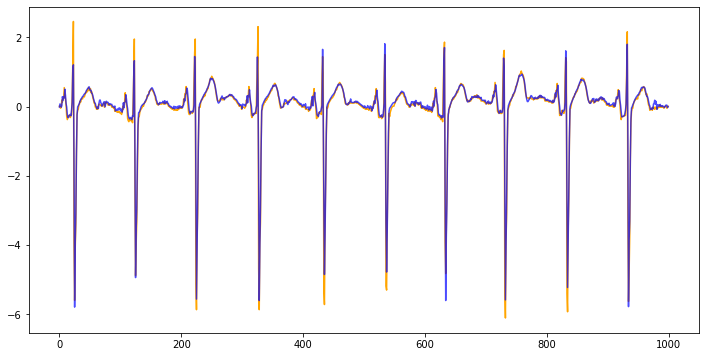

result for ks on test is KstestResult(statistic=0.298252976403666, pvalue=2.2934222647661855e-79)
result for ks on prediction is KstestResult(statistic=0.9999999709079752, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.9352684164711816, pvalue=0.0)


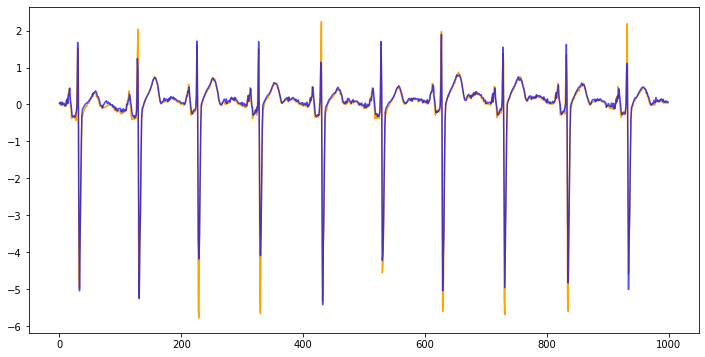

result for ks on test is KstestResult(statistic=0.323724561448688, pvalue=8.950981752089667e-94)
result for ks on prediction is KstestResult(statistic=0.9999999962616267, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.9330300210779789, pvalue=0.0)


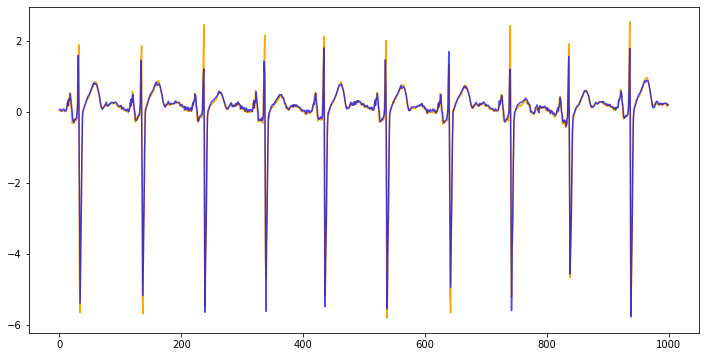

result for ks on test is KstestResult(statistic=0.3118799773676962, pvalue=6.501495674751812e-87)
result for ks on prediction is KstestResult(statistic=0.9999999974813805, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.9257972442185469, pvalue=0.0)


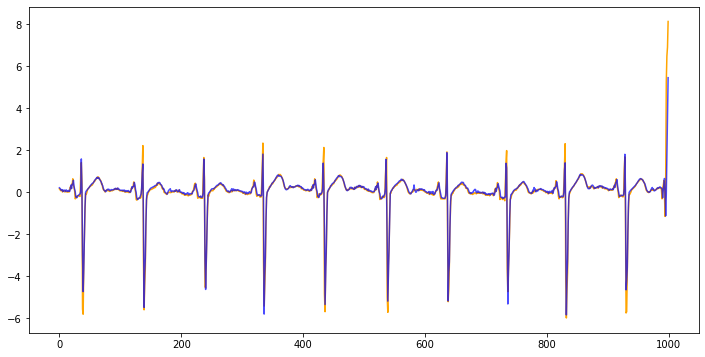

result for ks on test is KstestResult(statistic=0.21428527733806974, pvalue=8.828726975339273e-41)
result for ks on prediction is KstestResult(statistic=1.0, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.9317233715218076, pvalue=0.0)


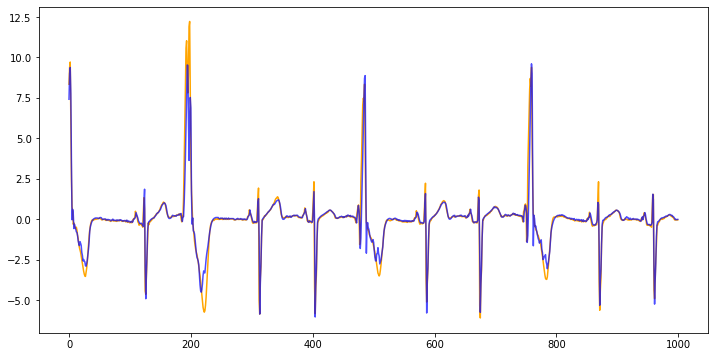

result for ks on test is KstestResult(statistic=0.306724561448688, pvalue=5.148991631686757e-84)
result for ks on prediction is KstestResult(statistic=0.9999999930516926, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.9398721839177935, pvalue=0.0)


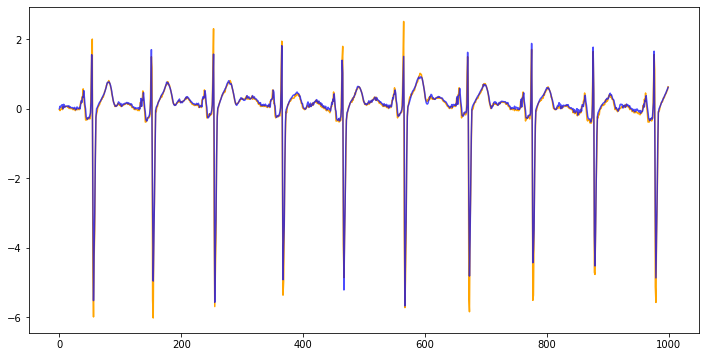

result for ks on test is KstestResult(statistic=0.23728527733806976, pvalue=5.081744819079937e-50)
result for ks on prediction is KstestResult(statistic=1.0, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.940839293007104, pvalue=0.0)


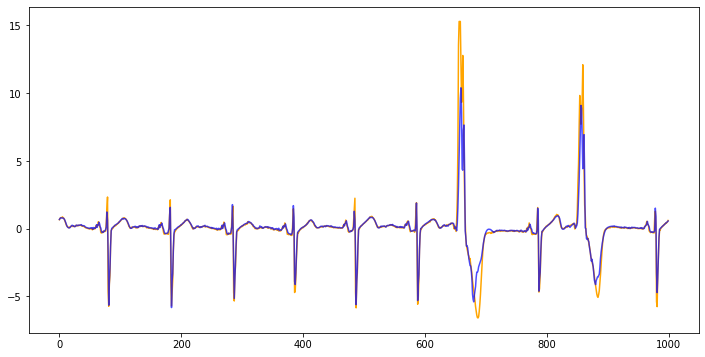

result for ks on test is KstestResult(statistic=0.30528527733806976, pvalue=3.247471043874269e-83)
result for ks on prediction is KstestResult(statistic=0.9999999919261364, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.944122454184194, pvalue=0.0)


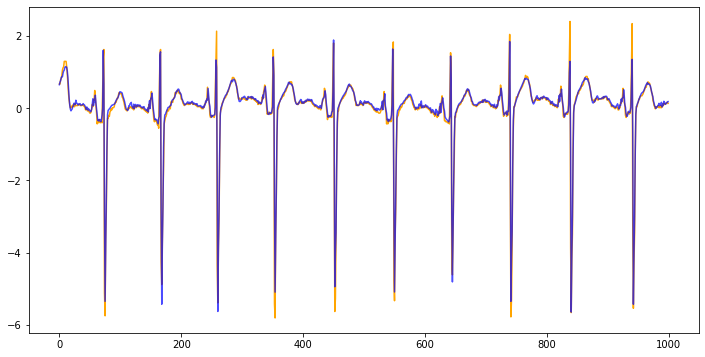

result for ks on test is KstestResult(statistic=0.30612970983972143, pvalue=1.7422919939297377e-54)
result for ks on prediction is KstestResult(statistic=0.9999999973358376, pvalue=0.0)
Results for spearman correlation is SpearmanrResult(correlation=0.946263124332167, pvalue=2.0896e-319)


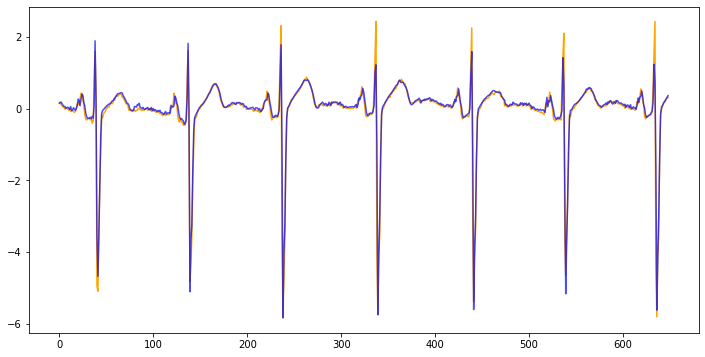

In [117]:
for x, y in val_data_multi.take(10):
    num_in = create_time_steps(len(x))
    num_out = len(y)
    prediction = multi_step_model.predict(x)
    
    ks_test = stats.kstest(np.array(y),'norm')
    ks_pred = stats.kstest(np.array(prediction),'norm')
    
    print(f'result for ks on test is {ks_test}')
    print(f'result for ks on prediction is {ks_pred}')
    
    if (ks_test[1] >=0.05) and (ks_pred[1] >= 0.05):
        print(f'Results for pearson correlation is {stats.pearsonr(np.array(pd.DataFrame(y)[0]),np.array(pd.DataFrame(prediction)[0]))}')
    else:
        print(f'Results for spearman correlation is {stats.spearmanr((np.array(pd.DataFrame(y)[0])),(np.array(pd.DataFrame(prediction)[0])))}')
        #pass
    
    plt.figure(figsize=(12, 6))
    #plt.plot(num_in, np.array(x[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(y),label='True Future',color='orange')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction),color='blue',alpha=0.7)
    plt.show()

## 7500 passos de treino

### Entender melhor a saída do modelo

### Previsões variando o número de passos no futuro

### Gerar 1000 pontos de uma parábola, jogar no csv, treinar e testar.
### Gerar e jogar para mais pontos

### Algoritmo de deslocamento no tempo com passo pequeno, e recalculando a correlação (Para descobrir o espaço onde a correlação é maxima).
### Fazer um gráfico da correlação em função do deslocamento temporal.

### Gráfico correlação em função do percentual de tempo do teste.

### Criar um ruído aleatório no dado para fazer o filtro

### Ruído Elétrico Muscular
### Sinais Mioelétricos

#### Guyton Fisiologia 12 ed
#### entre 10 ~ 13